<a href="https://colab.research.google.com/github/bhathiya-pilanawithana/Case-study-Kaggle-Sales-Forecasting-Favorita/blob/main/Case_Study_Grocery_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First login to your Kaggle account and register to the competetion. Then create a token in Kaggle to use the Kaggle API. This will download 'kaggle.json' file to the local computer. (Use instructions in Method-2, Step-2 in https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/)

Then upload the json file to the root folder and run the following cell. It will download the dataset as a .zip file to the root.

In [1]:
! pip install -q kaggle
!mkdir ~/.kaggle #If the folder exists, comment this!
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c favorita-grocery-sales-forecasting

The following is to unzip the  downloaded main .zip file and unzip the indivigual 7zip files contained in the main .zip file.

In [2]:
import zipfile
with zipfile.ZipFile('favorita-grocery-sales-forecasting.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

!7z e /content/data/holidays_events.csv.7z -aoa
!7z e /content/data/items.csv.7z -aoa
!7z e /content/data/oil.csv.7z -aoa
!7z e /content/data/stores.csv.7z -aoa
!7z e /content/data/test.csv.7z -aoa
!7z e /content/data/train.csv.7z -aoa
!7z e /content/data/transactions.csv.7z -aoa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/data/                        1 file, 1898 bytes (2 KiB)

Extracting archive: /content/data/holidays_events.csv.7z
--
Path = /content/data/holidays_events.csv.7z
Type = 7z
Physical Size = 1898
Headers Size = 146
Method = LZMA2:24k
Solid = -
Blocks = 1

  0%    Everything is Ok

Size:       22309
Compressed: 1898

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/data/                        1 file, 14315 bytes (14 KiB)

Extracting archive: /con

### Reading Training CSV file

The csv file 'train' is too large to be loaded fully into the compute with 12GB RAM. Therefore, the following two code cells use chunking to read the csv file chunk by chunk and appended or skip the chunk based on chunk's date range.

In [27]:
import pandas as pd
import numpy as np
import gc

df_train_chunks = pd.read_csv(
    'train.csv',
    parse_dates = ['date'],
    date_format = '%d/%m/%Y',
    chunksize = 5000000,
    dtype = {
        'id': np.int64,
        'store_nbr': np.int64,
        'item_nbr': np.int64,
        'unit_sales': np.float64,
        },
    low_memory = False
)

In [28]:
# The initial_cutoff_date below will be used to check whether the chunk in process should be
# appended to the final dataframe or skipped. Every chunk with maximum date larger than the
# initial_cutoff_date will be appended to the final dataframe.

initial_cutoff_date = pd.to_datetime('2017-03-01', format='%Y-%m-%d')
df_all = pd.DataFrame()
for chunk in df_train_chunks:
  min_date = pd.to_datetime(chunk['date'].min(), format='%Y-%m-%d')
  max_date = pd.to_datetime(chunk['date'].max(), format='%Y-%m-%d')
  print(f'Chunk in process: from {min_date} to {max_date}')

  if max_date > initial_cutoff_date:
    print('\tAppending.')
    if df_all.empty:
      df_all = chunk.copy()
    else:
      df_all = pd.concat([df_all, chunk]).reset_index(drop=True)
  else:
    print('\tSkipping.')

del(chunk)

min_date = df_all['date'].min()
max_date = df_all['date'].max()
print(f'Final date range in data is from {min_date} to {max_date}.')

df_all['date'] = pd.to_datetime(df_all['date'], format='%Y-%m-%d') #Convert Date column
df_all = df_all.drop('id', axis=1) #ID column is not required

df_all['store_nbr'] = df_all['store_nbr'].astype('int32') #Downcast into int32 to save memory
df_all['item_nbr'] = df_all['item_nbr'].astype('int32') #Downcast into int32 to save memory

gc.collect()

Chunk in process: from 2013-01-01 00:00:00 to 2013-05-01 00:00:00
	Skipping.
Chunk in process: from 2013-05-01 00:00:00 to 2013-08-21 00:00:00
	Skipping.
Chunk in process: from 2013-08-21 00:00:00 to 2013-12-05 00:00:00
	Skipping.
Chunk in process: from 2013-12-05 00:00:00 to 2014-03-06 00:00:00
	Skipping.
Chunk in process: from 2014-03-06 00:00:00 to 2014-06-07 00:00:00
	Skipping.
Chunk in process: from 2014-06-07 00:00:00 to 2014-09-01 00:00:00
	Skipping.
Chunk in process: from 2014-09-01 00:00:00 to 2014-11-11 00:00:00
	Skipping.
Chunk in process: from 2014-11-11 00:00:00 to 2015-01-25 00:00:00
	Skipping.
Chunk in process: from 2015-01-25 00:00:00 to 2015-04-17 00:00:00
	Skipping.
Chunk in process: from 2015-04-17 00:00:00 to 2015-06-27 00:00:00
	Skipping.
Chunk in process: from 2015-06-27 00:00:00 to 2015-08-27 00:00:00
	Skipping.
Chunk in process: from 2015-08-27 00:00:00 to 2015-10-22 00:00:00
	Skipping.
Chunk in process: from 2015-10-22 00:00:00 to 2015-12-15 00:00:00
	Skipping.

32521

In [29]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20497040 entries, 0 to 20497039
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int32         
 2   item_nbr     int32         
 3   unit_sales   float64       
 4   onpromotion  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int32(2)
memory usage: 488.7 MB


In [30]:
#Check the number of unique items and stores and their availability through out the training period

unique_dates = df_all['date'].unique()
print(f'There are {len(unique_dates)} days in total.')
all_dates = pd.date_range(min_date, max_date)
missing_dates = np.setdiff1d(all_dates, unique_dates)
print(f'There are {len(missing_dates)} missing dates between {min_date} and {max_date}')

unique_stores = df_all['store_nbr'].unique()
num_unique_stores = len(unique_stores)
unique_items  = df_all['item_nbr'].unique()
num_unique_items = len(unique_items)
print(f'There are {num_unique_stores} unique stores and {num_unique_items} unique items')

df_store_temp = df_all.groupby('date')['store_nbr'].nunique().reset_index()
store_mismatch = df_store_temp[df_store_temp['store_nbr'] < num_unique_stores]['date'].values
print(f'Not all the stores are available in {len(store_mismatch)} days.')
del df_store_temp
gc.collect();

There are 195 days in total.
There are 0 missing dates between 2017-02-02 and 2017-08-15
There are 54 unique stores and 4006 unique items
Not all the stores are available in 77 days.


In [5]:
#First date is removed due to possible improper chunking

df_all = df_all[df_all['date'] != min_date].copy()
gc.collect()

min_date = pd.to_datetime(df_all['date'].min(), format='%Y-%m-%d')
unique_dates = df_all['date'].unique()

In [6]:
# Turn target column unit_sales into log(unit_sales+1), since final performance
# is evaluated based on log(unit_sales+1)

df_all['unit_sales'] = np.log(np.clip(df_all['unit_sales'].values, a_min=0, a_max=None) + 1)

In [7]:
#--Create a hold out test set for final testing----------------------------------------
# Holdout test set is created such that it hold 16 days in the future for predictions.
# That means test_date is selected to be 2017-07-30, so that dates from 2017-07-31 to
# 2017-08-15 (16 days in total) is received for forecasting.

test_date = pd.to_datetime('2017-07-30', format='%Y-%m-%d')
df_holdout = df_all[(df_all['date'] >= test_date)].copy()
df_all = df_all[(df_all['date'] < test_date)].copy()
gc.collect()

0

In [8]:
# The training set lower cutoff date is selected such that the first "lag_window_max" days
# are reserved to build lagged features.

lag_window_max = 7
train_cutoff_lower = min_date + pd.Timedelta(days = lag_window_max)
print(f'With selected maximum lag window lower cutoff date for training is {train_cutoff_lower}')

With selected maximum lag window lower cutoff date for training is 2017-02-10 00:00:00


In [9]:
# Hold-out test set requires history build lagged features.
# Therefore, hold-out test set is appended with lag_window_max
# number of days in history with respect to test_date

df_holout_history = df_all[(df_all['date'] < test_date) & (df_all['date'] >= test_date - pd.Timedelta(days = lag_window_max))].copy()
df_holdout = pd.concat([df_holdout, df_holout_history]).sort_values(by='date').reset_index(drop=True)

del df_holout_history
gc.collect()

0

In [10]:
#--Merge Store and Item dataframes-------------------------------------------
def merge_item(df_all):
  df_item = pd.read_csv('items.csv')
  df_all = df_all.merge(df_item, on='item_nbr', how='left')

  del df_item
  gc.collect()

  return df_all

df_all = merge_item(df_all)

In [11]:
#--Merge Store Dataframe-----------------------------------------------------
def merge_store(df_all):
  df_store = pd.read_csv('stores.csv')
  df_all = df_all.merge(df_store, on='store_nbr', how='left')

  del df_store
  gc.collect()

  return df_all

df_all = merge_store(df_all)

##### Model Set 1 - Aggregated Based on Item and Store Columns:

This model set is to produce predictions without item IDs. This is because new item ID s may be introduced to testing set as per the competition description. It is assumed that store IDs will remain constant.

In [12]:
# For this model item_nbr and store_nbr will not be used.
# Model will procude predictions based on store and item metadata

df_all_model1 = df_all.drop(['item_nbr', 'store_nbr'], axis=1)
del df_all #If there are other model sets, keep it.
gc.collect()

0

In [13]:
# Aggregate 'unit_sales' and 'onpromotion' columns grouped by store and item metadata.
# Unit sales is aggregated as the mean across same store and item metadata.
# Thus the model will produce predictions for the mean of uni_sales across store and item meta data.

df_all_model1_agg = df_all_model1.groupby(['date', 'city', 'state', 'type', 'cluster','family','class','perishable'])['unit_sales'].mean().reset_index()
df_all_model1_agg = df_all_model1_agg.rename(columns={'unit_sales': 'unit_sales_mean'})

df_all_model1_agg['promotion_sum'] = df_all_model1.groupby(['date','city', 'state', 'type', 'cluster','family','class','perishable'])['onpromotion'].sum().reset_index()['onpromotion'].astype('int32')

del df_all_model1
gc.collect()

0

In [14]:
#--Merge other dataframes----------------------------------------------------
def merge_oil_and_holidays(df_all):
  df_oil = pd.read_csv('oil.csv')
  df_oil['date'] = pd.to_datetime(df_oil['date'], format='%Y-%m-%d')
  df_all = df_all.merge(df_oil, on='date', how='left')
  df_all = df_all.rename(columns={'dcoilwtico': 'oil_price'})
  df_all['oil_price'] = df_all['oil_price'].astype('float32')

  df_holidays = pd.read_csv('holidays_events.csv')
  df_holidays['date'] = pd.to_datetime(df_holidays['date'], format='%Y-%m-%d')
  df_holidays = df_holidays[['date', 'type']]
  df_holidays = df_holidays.drop_duplicates()
  df_holidays = df_holidays.rename(columns={'type': 'holiday'})
  df_all = df_all.merge(df_holidays, on='date', how='left')
  df_all['holiday'] = df_all['holiday'].fillna('None')

  del df_oil, df_holidays
  gc.collect()

  return df_all

df_all_model1_agg = merge_oil_and_holidays(df_all_model1_agg)

#--Create Time Features------------------------------------------------------
def create_time_features(df_all):
  df_all['day_of_month'] = df_all['date'].dt.day.astype('int32')
  df_all['is_weekend'] = df_all['date'].dt.dayofweek.isin([5, 6]).astype('int32')
  df_all["pay_day"] = ((df_all["day_of_month"] == 15) | (df_all['date'].dt.is_month_end)).astype('int32')
  gc.collect();

  return df_all

df_all_model1_agg = create_time_features(df_all_model1_agg)
#----------------------------------------------------------------------------

In [15]:
# Downcast columns to save memory

#--Encode Catergorical Features as 'category' to Save RAM--------------------
def encode_cat(df_all):
  df_all['holiday'] = df_all['holiday'].astype('category')
  df_all['city'] = df_all['city'].astype('category')
  df_all['state'] = df_all['state'].astype('category')
  df_all['type'] = df_all['type'].astype('category')
  df_all['cluster'] = df_all['cluster'].astype('category')
  df_all['family'] = df_all['family'].astype('category')
  df_all['class'] = df_all['class'].astype('int32')
  df_all['perishable'] = df_all['perishable'].astype('int32')

  gc.collect()
  return df_all

df_all_model1_agg = encode_cat(df_all_model1_agg)
#----------------------------------------------------------------------------

In [16]:
df_all_model1_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1651705 entries, 0 to 1651704
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1651705 non-null  datetime64[ns]
 1   city             1651705 non-null  category      
 2   state            1651705 non-null  category      
 3   type             1651705 non-null  category      
 4   cluster          1651705 non-null  category      
 5   family           1651705 non-null  category      
 6   class            1651705 non-null  int32         
 7   perishable       1651705 non-null  int32         
 8   unit_sales_mean  1651705 non-null  float64       
 9   promotion_sum    1651705 non-null  int32         
 10  oil_price        1116018 non-null  float32       
 11  holiday          1651705 non-null  category      
 12  day_of_month     1651705 non-null  int32         
 13  is_weekend       1651705 non-null  int32         
 14  pa

In [17]:
def created_lagged_features_model1(df_all, lag_window_max):
  df_all = df_all.sort_values(by=['date']).reset_index(drop=True)

  for lag in range(1, lag_window_max + 1):
    df_all[f'unit_sales_lag_{lag}'] = df_all.groupby(['city', 'state', 'type', 'cluster', 'family', 'class', 'perishable'], observed=False)['unit_sales_mean'].shift(lag).astype('float32')
    df_all[f'promotion_lag_{lag}']  = df_all.groupby(['city', 'state', 'type', 'cluster', 'family', 'class', 'perishable'], observed=False)['promotion_sum'].shift(lag).astype('float32')

  for lag in range(1, lag_window_max + 1):
    df_all[f'unit_sales_diff_{lag}'] = df_all.groupby(['city', 'state', 'type', 'cluster', 'family', 'class', 'perishable'], observed=False)['unit_sales_mean'].diff(lag).astype('float32')
    df_all[f'promotion_diff_{lag}']  = df_all.groupby(['city', 'state', 'type', 'cluster', 'family', 'class', 'perishable'], observed=False)['promotion_sum'].diff(lag).astype('float32')

  for lag in range(2, lag_window_max + 1):
    df_all[f'unit_sales_mean_{lag}'] = df_all.groupby(['city', 'state', 'type', 'cluster', 'family', 'class', 'perishable'], observed=False)['unit_sales_mean'].rolling(window=lag).mean().reset_index(drop=True).astype('float32')
    df_all[f'promotion_mean_{lag}']  = df_all.groupby(['city', 'state', 'type', 'cluster', 'family', 'class', 'perishable'], observed=False)['promotion_sum'].rolling(window=lag).mean().reset_index(drop=True).astype('float32')

  for lag in range(2, lag_window_max + 1):
    df_all[f'unit_sales_std_{lag}'] = df_all.groupby(['city', 'state', 'type', 'cluster', 'family', 'class', 'perishable'], observed=False)['unit_sales_mean'].rolling(window=lag).std().reset_index(drop=True).astype('float32')
    df_all[f'promotion_std_{lag}']  = df_all.groupby(['city', 'state', 'type', 'cluster', 'family', 'class', 'perishable'], observed=False)['promotion_sum'].rolling(window=lag).std().reset_index(drop=True).astype('float32')

  return df_all

df_all_model1_agg = created_lagged_features_model1(df_all_model1_agg, lag_window_max)

In [18]:
# Obtain the targets for training for each feature vector.
# Targets are obtained by shifting the unit_sales appropiately

def create_targets(df_all):
  df_all = df_all.sort_values(by=['date']).reset_index(drop=True)

  for i in range(1,16+1):
    df_all[f'target_{i}'] = df_all.groupby(['city', 'state', 'type', 'cluster', 'family', 'class', 'perishable'], observed=False)['unit_sales_mean'].shift(-i).fillna(0)

  return df_all

df_all_model1_agg = create_targets(df_all_model1_agg)

### The below code cells produce plots to analys the relationship between target and features.

<ipython-input-20-e343b2378975>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_all_model1_agg.groupby('holiday')['unit_sales_mean'].mean().plot(kind='bar')


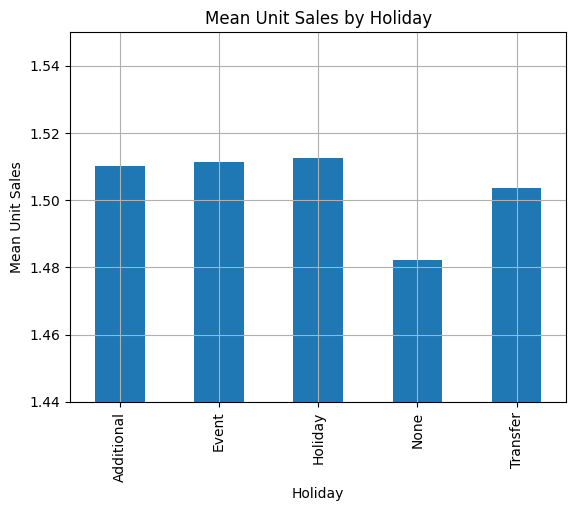

In [20]:
#Generate bar chart of 'unit_sales' based on values of 'holiday'

import matplotlib.pyplot as plt
import seaborn as sns

df_all_model1_agg.groupby('holiday')['unit_sales_mean'].mean().plot(kind='bar')
plt.ylim(1.44,1.55)
plt.title('Mean Unit Sales by Holiday')
plt.ylabel('Mean Unit Sales')
plt.xlabel('Holiday')
plt.grid()
plt.show()

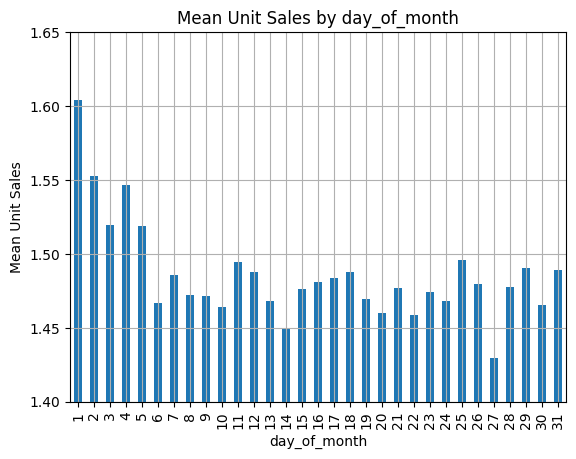

In [ ]:
#Generate a scatter plot of 'unit_sales' with 'oil_price'

import matplotlib.pyplot as plt
import seaborn as sns

df_all_model1_agg.groupby('day_of_month')['unit_sales_mean'].mean().plot(kind='bar')
plt.ylim(1.4,1.65)
plt.title('Mean Unit Sales by day_of_month')
plt.ylabel('Mean Unit Sales')
plt.xlabel('day_of_month')
plt.grid()
plt.show()

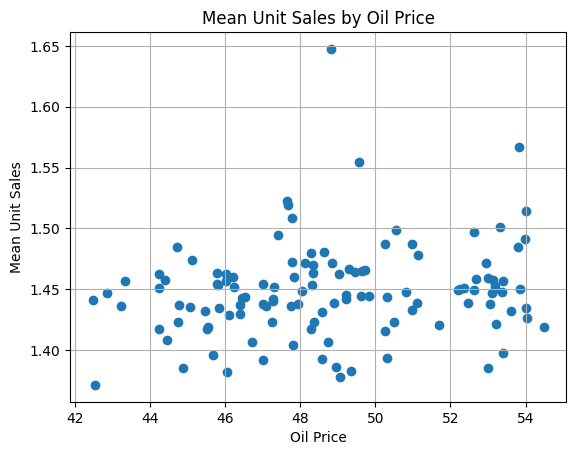

In [ ]:
#Generate bar chart of 'unit_sales' based on values of 'day_of_month'

import matplotlib.pyplot as plt
import seaborn as sns

df_temp = df_all_model1_agg.groupby('date')['unit_sales_mean'].mean().reset_index()
df_temp['oil_price'] = df_all_model1_agg.groupby('date')['oil_price'].mean().reset_index()['oil_price']

plt.scatter(df_temp['oil_price'], df_temp['unit_sales_mean'])
plt.title('Mean Unit Sales by Oil Price')
plt.ylabel('Mean Unit Sales')
plt.xlabel('Oil Price')
plt.grid()
plt.show()

### Training of the model

In [19]:
import lightgbm as lgb

df_train = df_all_model1_agg[(df_all_model1_agg['date'] >= train_cutoff_lower) & (df_all_model1_agg['date'] < test_date)]

model_parameters = {
    'num_leaves': 80,
    'min_data_in_leaf': 200,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    "max_bin": 350,
    'objective': 'regression',
    'metric': 'l2',
    "verbose": 0,
    }

cat_columns = ['family', 'class', 'perishable', 'city', 'state', 'type', 'cluster', 'holiday', 'day_of_month', 'is_weekend', 'pay_day']
lag_cols = [f'unit_sales_lag_{i}' for i in range(1,lag_window_max+1)] + [f'promotion_lag_{i}' for i in range(1,lag_window_max+1)]
diff_cols = [f'unit_sales_diff_{i}' for i in range(1,lag_window_max+1)] + [f'promotion_diff_{i}' for i in range(1,lag_window_max+1)]
mean_cols = [f'unit_sales_mean_{i}' for i in range(2,lag_window_max+1)] + [f'promotion_mean_{i}' for i in range(2,lag_window_max+1)]
std_cols = [f'unit_sales_std_{i}' for i in range(2,lag_window_max+1)] + [f'promotion_std_{i}' for i in range(2,lag_window_max+1)]

train_columns = cat_columns + lag_cols + diff_cols + mean_cols + std_cols

lgb_model_set1 = []
for i in range(1,16+1):
  print(f'Training for unit sales {i} days in future.')
  df_train_i = df_train[df_train['date'] <= test_date - pd.Timedelta(days = i)].copy()
  train_min_date = df_train_i['date'].min()
  train_max_date = df_train_i['date'].max()
  print(f'\tTraining set from {train_min_date} to {train_max_date}')
  lgb_train = lgb.Dataset(df_train_i[train_columns], df_train_i[f'target_{i}'], categorical_feature=cat_columns)
  gbm = lgb.train(
    model_parameters,
    lgb_train,
    num_boost_round=200
    )
  lgb_model_set1.append(gbm)
  print(f'\tTraining for unit sales {i} days in future completed.')

del df_train_i
gc.collect()

Training for unit sales 1 days in future.
	Training set from 2017-02-10 00:00:00 to 2017-07-29 00:00:00
	Training for unit sales 1 days in future completed.
Training for unit sales 2 days in future.
	Training set from 2017-02-10 00:00:00 to 2017-07-28 00:00:00
	Training for unit sales 2 days in future completed.
Training for unit sales 3 days in future.
	Training set from 2017-02-10 00:00:00 to 2017-07-27 00:00:00
	Training for unit sales 3 days in future completed.
Training for unit sales 4 days in future.
	Training set from 2017-02-10 00:00:00 to 2017-07-26 00:00:00
	Training for unit sales 4 days in future completed.
Training for unit sales 5 days in future.
	Training set from 2017-02-10 00:00:00 to 2017-07-25 00:00:00
	Training for unit sales 5 days in future completed.
Training for unit sales 6 days in future.
	Training set from 2017-02-10 00:00:00 to 2017-07-24 00:00:00
	Training for unit sales 6 days in future completed.
Training for unit sales 7 days in future.
	Training set fr

77

### Inferencing for the Test Date

In [20]:
# Date preparation for inferencing. Using the same functions used for training data preparation


df_test_day = df_holdout[df_holdout['date'] <= test_date].copy()
df_future   = df_holdout[df_holdout['date'] >  test_date].copy()

#del df_holdout
gc.collect()

df_test_day = merge_item(df_test_day)
df_test_day = merge_store(df_test_day)
df_test_day_model1 = df_test_day.drop(['item_nbr', 'store_nbr'], axis=1)
#del df_test_day #If there are other model sets, keep it.
gc.collect()

#-Aggregate by Item and Store columns-----------------------------
df_test_day_model1_agg = df_test_day_model1.groupby(['date', 'city', 'state', 'type', 'cluster','family','class','perishable'])['unit_sales'].mean().reset_index()
df_test_day_model1_agg = df_test_day_model1_agg.rename(columns={'unit_sales': 'unit_sales_mean'})

df_test_day_model1_agg['promotion_sum'] = df_test_day_model1.groupby(['date','city', 'state', 'type', 'cluster','family','class','perishable'])['onpromotion'].sum().reset_index()['onpromotion'].astype('int32')

#del df_test_day_model1
gc.collect()
#-------------------------------------------------------

df_test_day_model1_agg = merge_oil_and_holidays(df_test_day_model1_agg)

df_test_day_model1_agg = create_time_features(df_test_day_model1_agg)

df_test_day_model1_agg = encode_cat(df_test_day_model1_agg)

df_test_day_model1_agg = created_lagged_features_model1(df_test_day_model1_agg, lag_window_max)

In [21]:
# Use the trained models to produce forecasts for each forecasting date.

df_test_day_model1_agg = df_test_day_model1_agg[df_test_day_model1_agg['date'] == test_date].copy()

for i in range(1,16+1):
  print(f'Predicting for unit sales {i} days in future.')
  df_test_day_model1_agg[f'unit_sales_prediction_day+{i}'] = lgb_model_set1[i-1].predict(df_test_day_model1_agg[train_columns])
  print(f'\tPredicting for unit sales {i} days in future completed.')

gc.collect()

Predicting for unit sales 1 days in future.
	Predicting for unit sales 1 days in future completed.
Predicting for unit sales 2 days in future.
	Predicting for unit sales 2 days in future completed.
Predicting for unit sales 3 days in future.
	Predicting for unit sales 3 days in future completed.
Predicting for unit sales 4 days in future.
	Predicting for unit sales 4 days in future completed.
Predicting for unit sales 5 days in future.
	Predicting for unit sales 5 days in future completed.
Predicting for unit sales 6 days in future.
	Predicting for unit sales 6 days in future completed.
Predicting for unit sales 7 days in future.
	Predicting for unit sales 7 days in future completed.
Predicting for unit sales 8 days in future.
	Predicting for unit sales 8 days in future completed.
Predicting for unit sales 9 days in future.
	Predicting for unit sales 9 days in future completed.
Predicting for unit sales 10 days in future.
	Predicting for unit sales 10 days in future completed.
Predicti

In [22]:
prediction_columns = ['city', 'state', 'type', 'cluster', 'family', 'class', 'perishable'] + [ f'unit_sales_prediction_day+{i}' for i in range(1,16+1)] + ['unit_sales_mean_2', 'unit_sales_lag_1']
df_test_day_model1_agg = df_test_day_model1_agg[prediction_columns]

df_future = merge_item(df_future)
df_future = merge_store(df_future)
df_future = df_future.merge(df_test_day_model1_agg, on=['city', 'state', 'type', 'cluster', 'family', 'class', 'perishable'], how='left')
#del df_test_day_model1_agg
gc.collect()

df_future['unit_sales_prediction_model1'] = 0.0
for i in range(1,16+1):
  df_future.loc[df_future['date'] == test_date + pd.Timedelta(days = i), 'unit_sales_prediction_model1'] = df_future.loc[df_future['date'] == test_date + pd.Timedelta(days = i), f'unit_sales_prediction_day+{i}']
df_future = df_future.drop([f'unit_sales_prediction_day+{i}' for i in range(1,16+1)], axis=1)

gc.collect()

0

In [23]:
#-For benchmarking and post processing-----------------------------------
df_future = df_future.rename(columns={'unit_sales_lag_1': 'unit_sales_prediction_lag1', 'unit_sales_mean_2': 'unit_sales_prediction_mean2'})
df_future['unit_sales_prediction_cnst0'] = 1
#------------------------------------------------------------------------

### Evaluate Model Performance and Benchmark

In [24]:
df_future['weight'] = df_future['perishable'].apply(lambda x: 1.25 if x == 1 else 1.0)

df_future['model1: error^2 * weight'] = df_future['weight'] * (df_future['unit_sales_prediction_model1'] - df_future['unit_sales'])**2
hold_out_score_model1 = np.sqrt(df_future['model1: error^2 * weight'].sum()/df_future['weight'].sum())
print(f'Hold-out score for Model1       : {hold_out_score_model1}')

df_future['cnst0: error^2 * weight'] = df_future['weight'] * (df_future['unit_sales_prediction_cnst0'] - df_future['unit_sales'])**2
hold_out_score_model1 = np.sqrt(df_future['cnst0: error^2 * weight'].sum()/df_future['weight'].sum())
print(f'Hold-out score for Constant One : {hold_out_score_model1}')

df_future['mean2: error^2 * weight'] = df_future['weight'] * (df_future['unit_sales_prediction_mean2'] - df_future['unit_sales'])**2
hold_out_score_model1 = np.sqrt(df_future['mean2: error^2 * weight'].sum()/df_future['weight'].sum())
print(f'Hold-out score for 2-day mean   : {hold_out_score_model1}')

Hold-out score for Model1       : 0.7362327842852232
Hold-out score for Constant One : 1.1106297976379111
Hold-out score for 2-day mean   : 0.9563308773078102


### Model Explanation

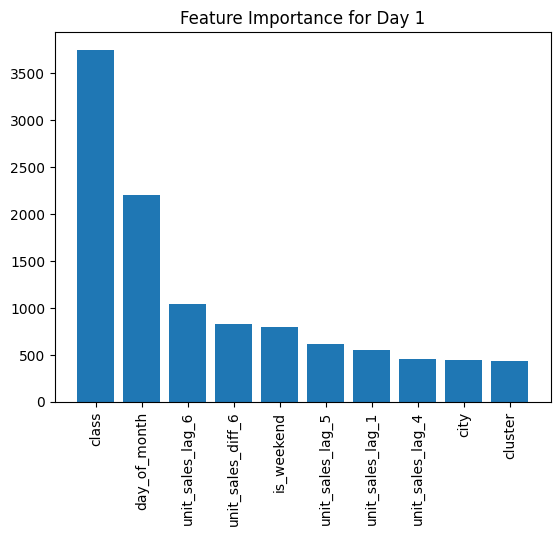

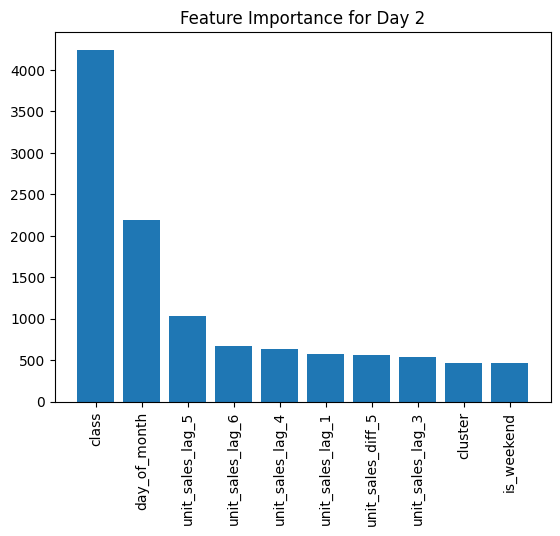

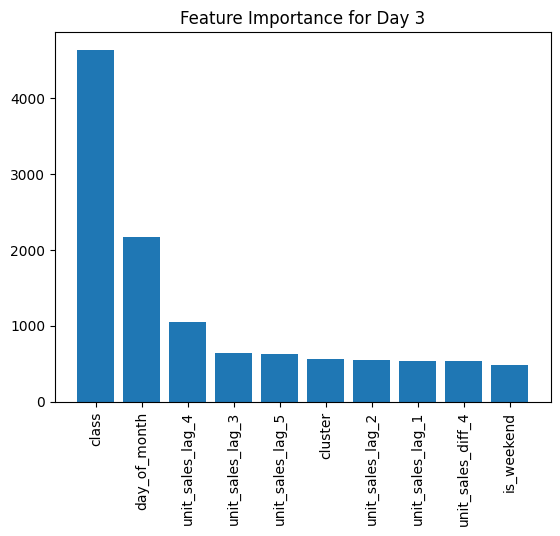

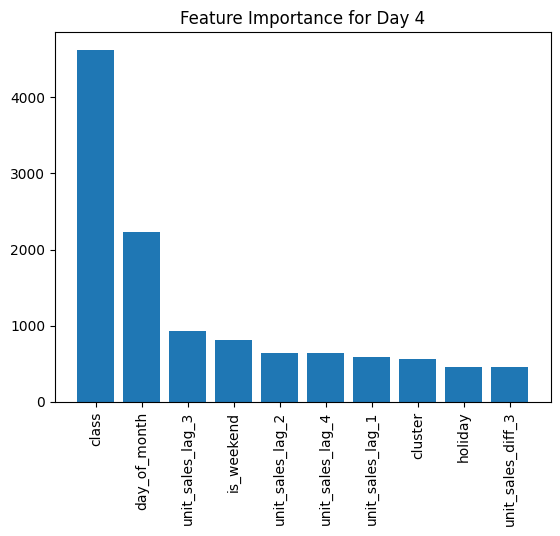

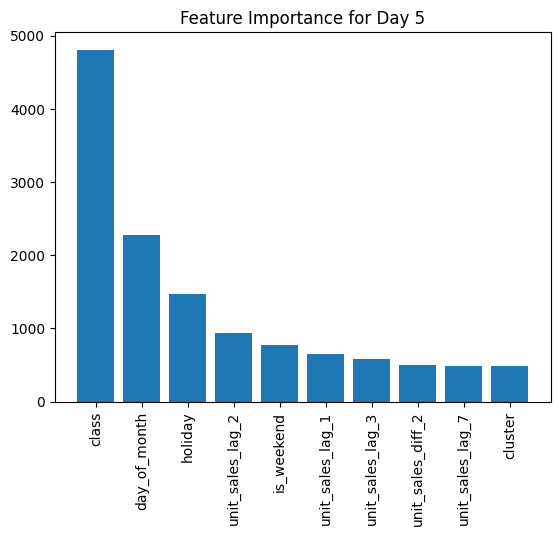

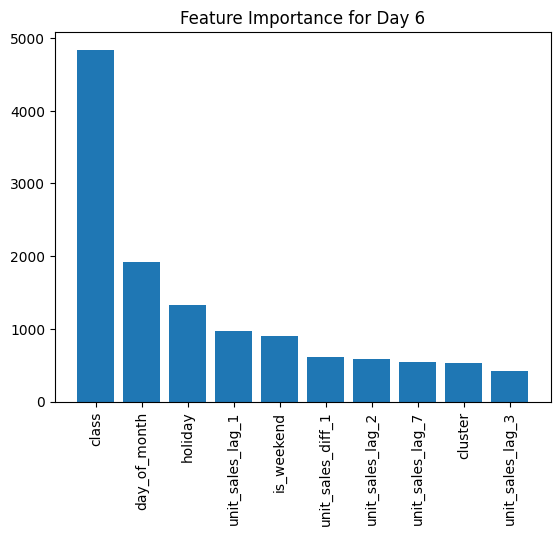

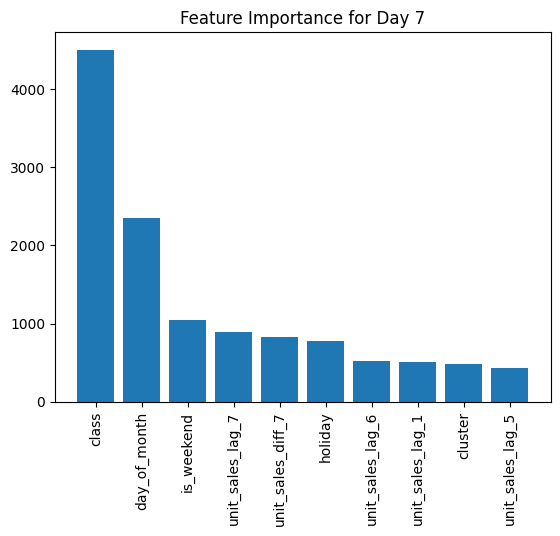

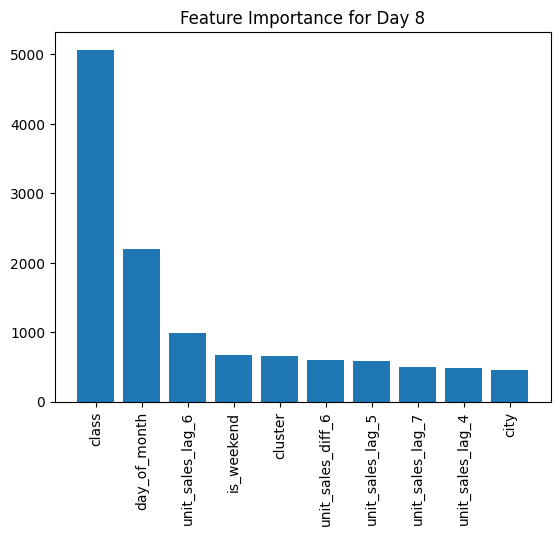

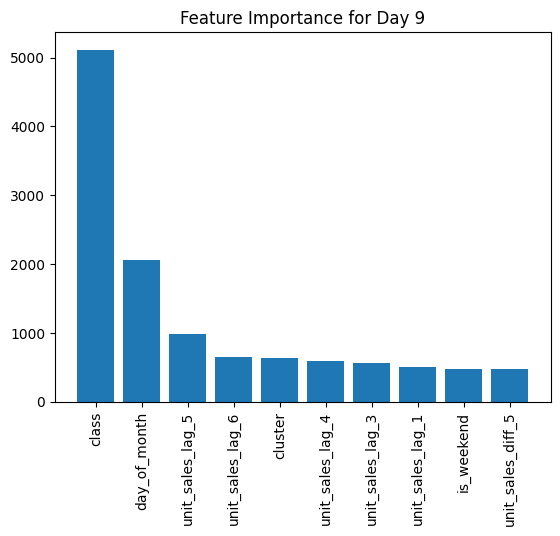

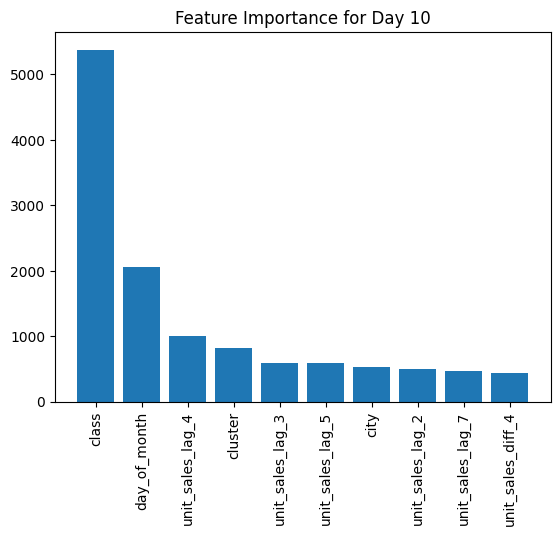

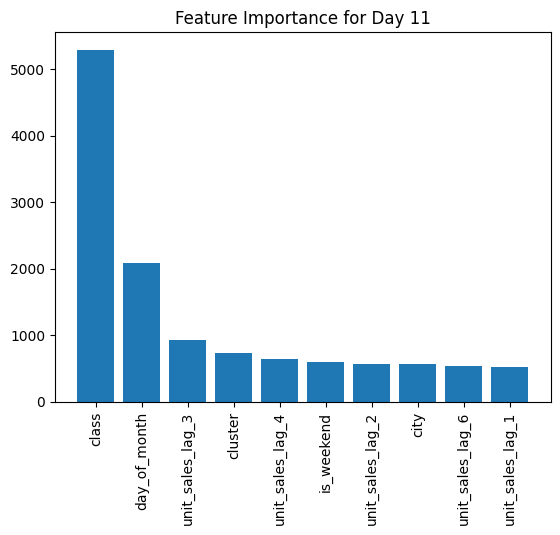

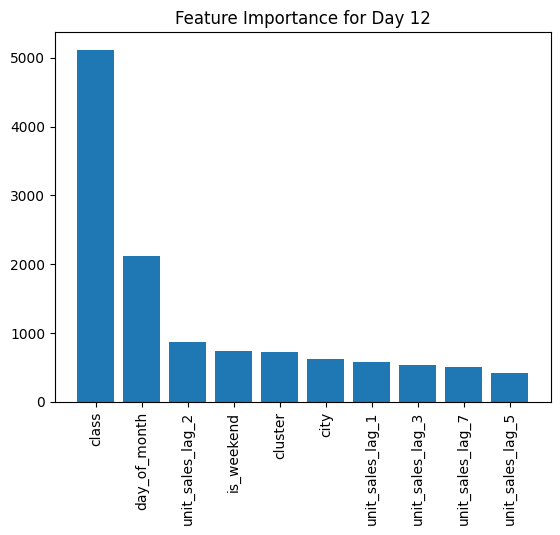

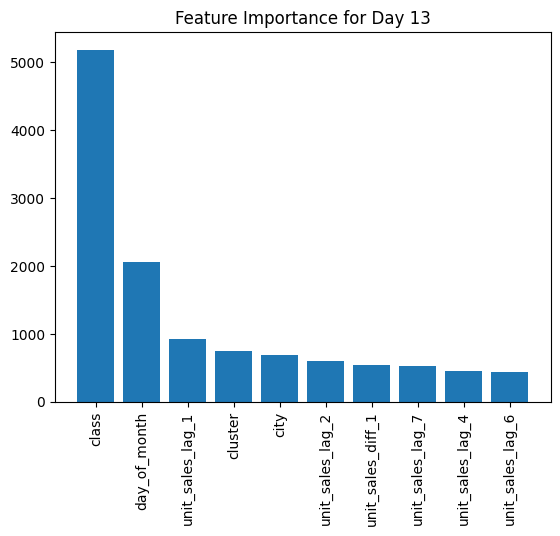

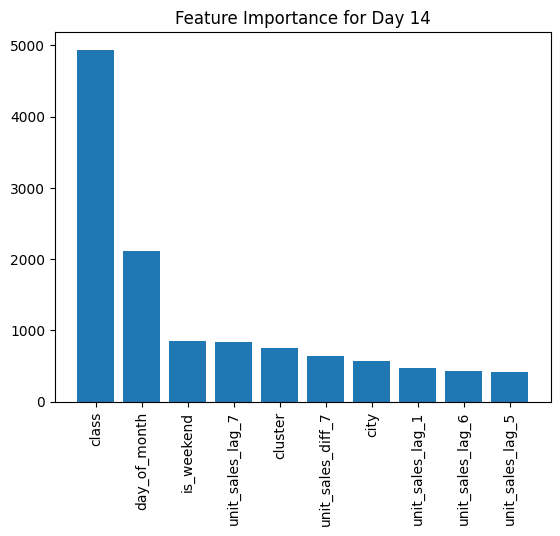

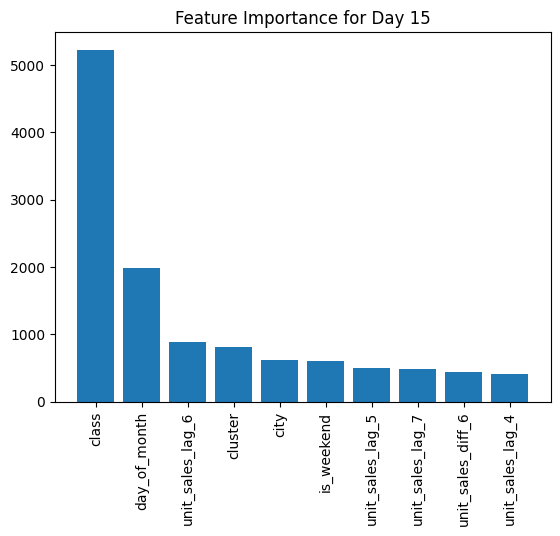

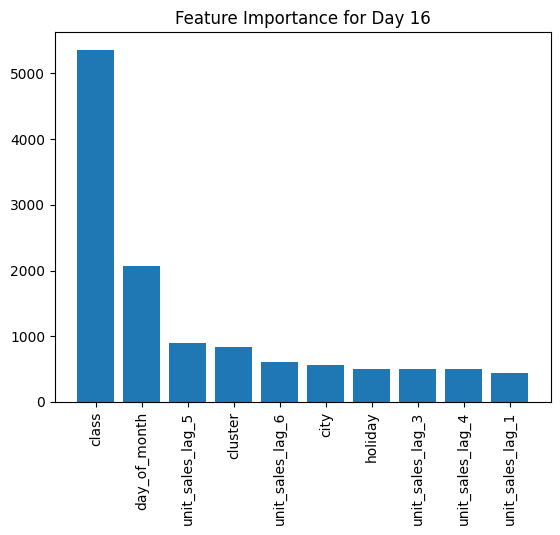

In [25]:
#plot feature importance for each forecasting day

import matplotlib.pyplot as plt
import seaborn as sns

for i in range(1,16+1):
  y = lgb_model_set1[i-1].feature_importance()
  x = train_columns

  #sort x and y both based on y
  y, x = zip(*sorted(zip(y, x), reverse=True))

  plt.bar(x[:10], y[:10])
  plt.title(f'Feature Importance for Day {i}')
  plt.xticks(rotation=90)
  plt.show()
